<a href="https://colab.research.google.com/github/sarahayek98/Detection-of-Alzheimer-using-3-ML/blob/main/Alzheimer_MRI_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU not active!


In [ ]:
pip install matplotlib


In [ ]:
from google.colab import drive
import os


# Mount Google Drive
drive.mount('/content/drive')


# Define the path to your folder
folder_name = 'Alzheimer Dataset'
folder_path = f'/content/drive/MyDrive/Alzheimer Dataset'

# List files in the folder
files = os.listdir(folder_path)
print(files)

Mounted at /content/drive
['test', 'train']


Target Value Distribution
Seeing the distribution of the target values is of critical importance in determining the methods to be applied in the subsequent steps.

A search has been initiated within the folder named 'train'.
There are 53 images in the ModerateDemented folder.
There are 717 images in the MildDemented folder.
There are 1792 images in the VeryMildDemented folder.
There are 2560 images in the NonDemented folder.
The search has been completed.


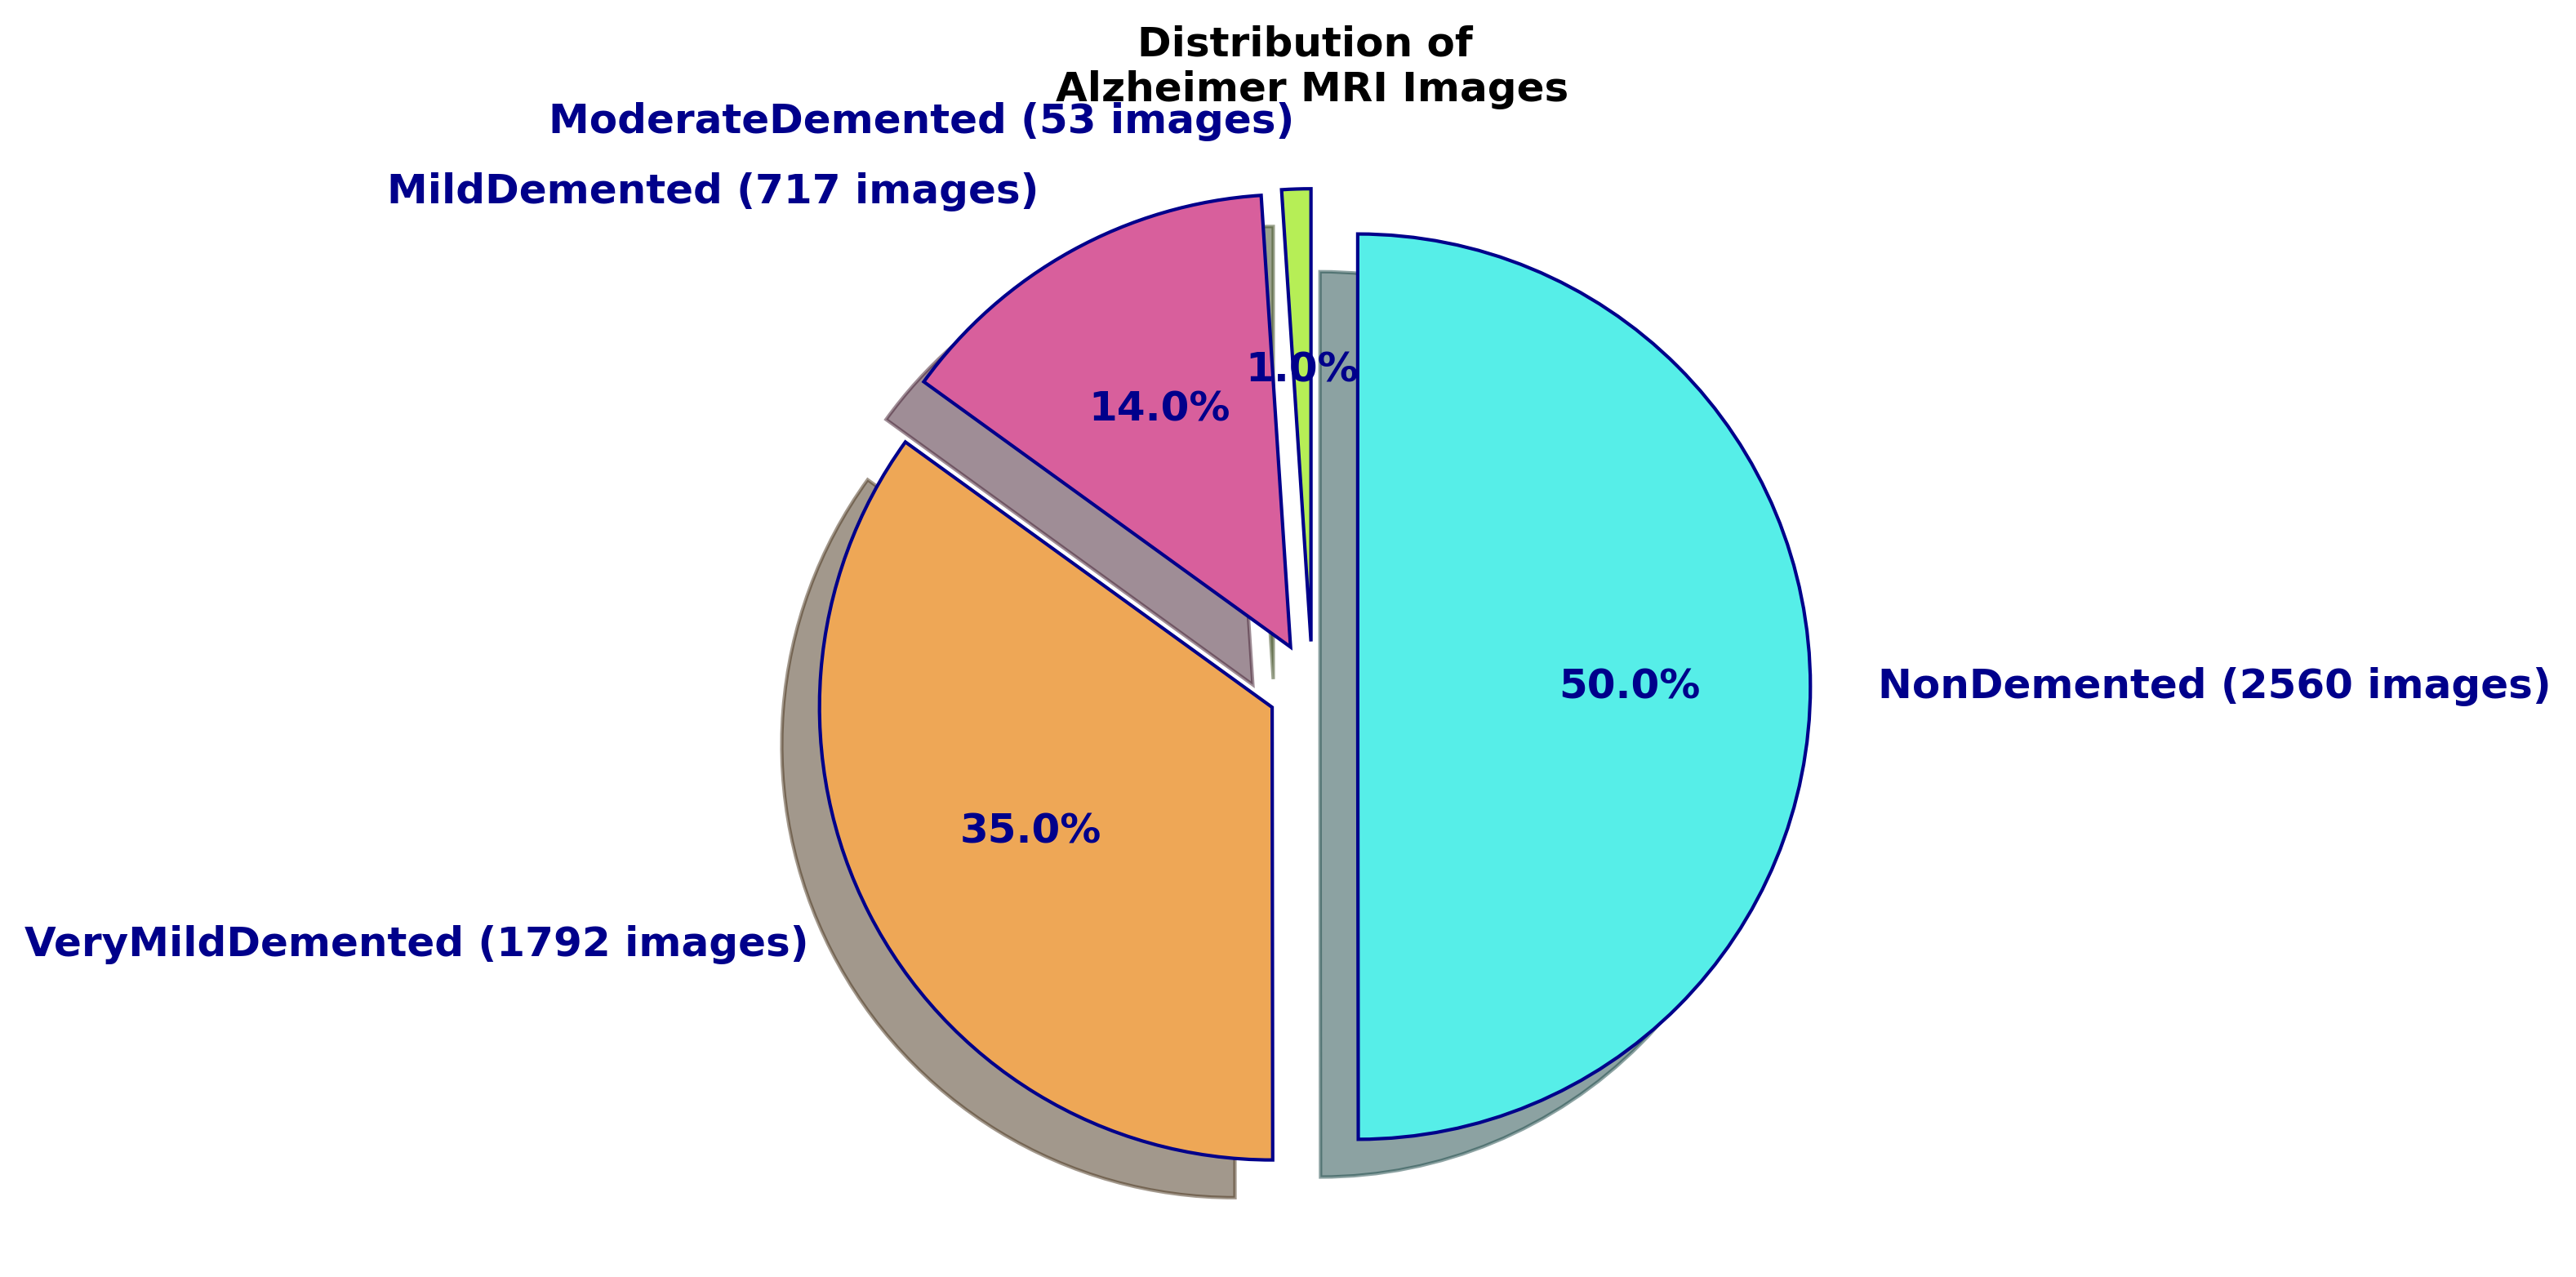

In [ ]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")

PATH = '/content/drive/MyDrive/Alzheimer Dataset/train'

image_counter(PATH)

Generate TF Dataset

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 5122 files belonging to 4 classes.


Pixel normalization improves the performance of a neural network. Therefore, we will go with pixel values from 0 to 1, rather than values in the range 0 to 255.

In [ ]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 0.9984069


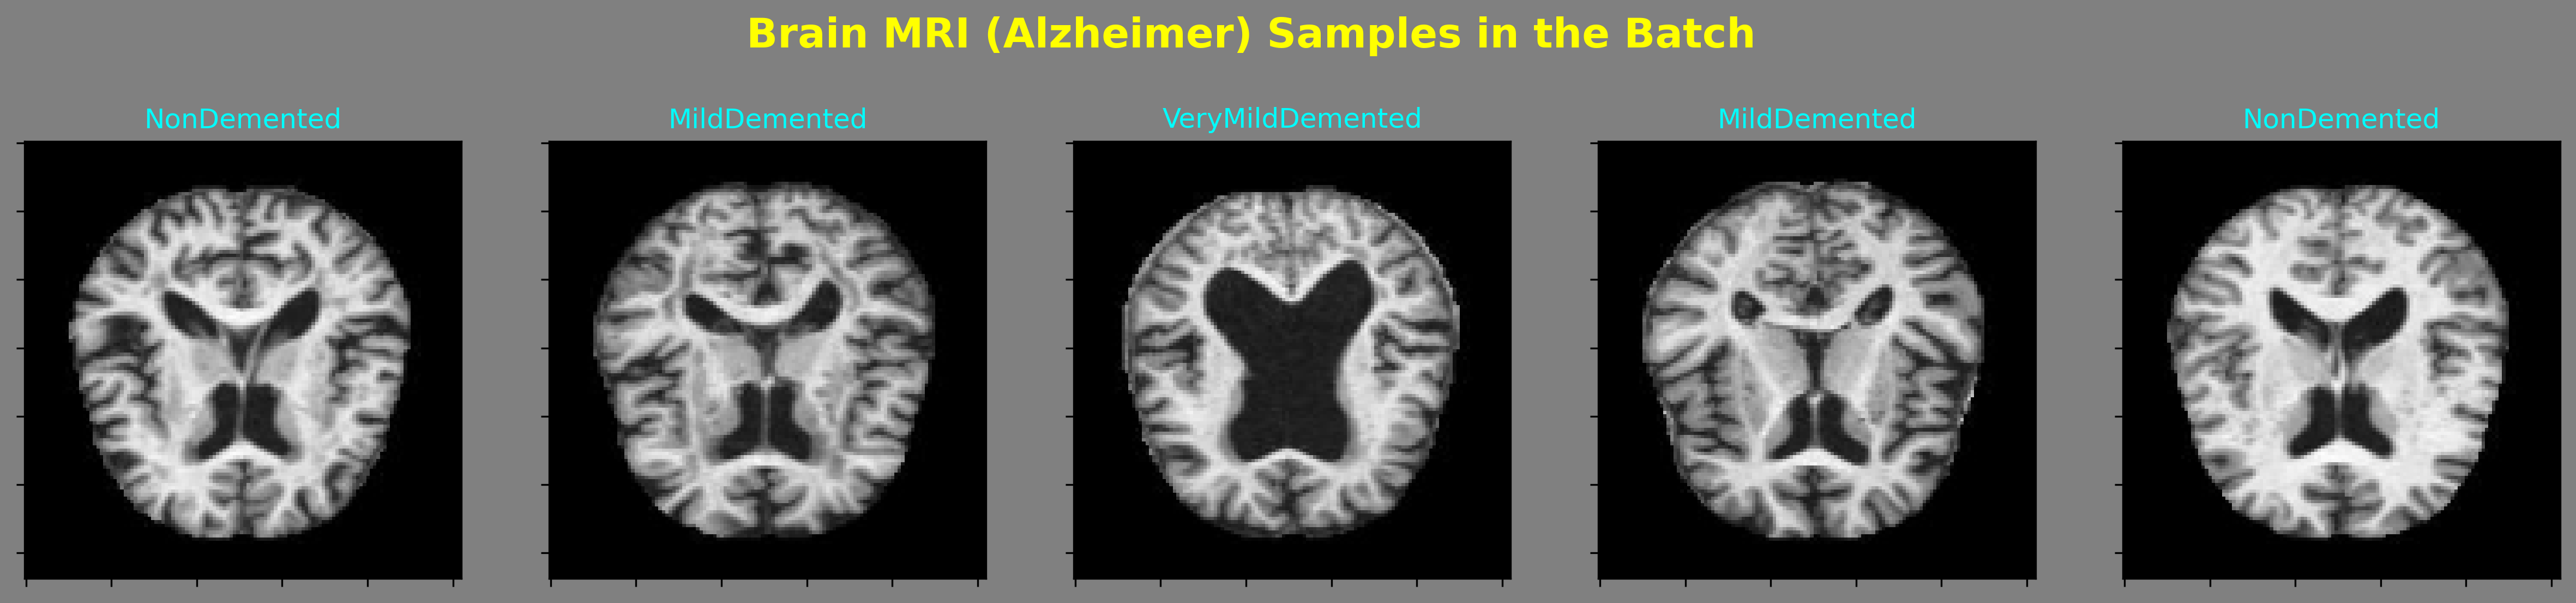

In [ ]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

We will divide the dataset into 80% training data, 10% validation data and 10% test data.

In [ ]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

We have an imbalanced distribution of target class. When dealing with an imbalanced target class distribution, using class weights can help the model perform better and effectively recognize the minority classes. Therefore, let's calculate the weights of the target classes in our training data and provide this information to our model during training.

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

Model Building

In [ ]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

Callbacks

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 1.6250 - accuracy: 0.2974
Epoch 1: val_accuracy improved from -inf to 0.38477, saving model to /tmp/checkpoint
128/128 [==============================] - 171s 1s/step - loss: 1.6250 - accuracy: 0.2974 - val_loss: 1.2652 - val_accuracy: 0.3848
Epoch 2/20
128/128 [==============================] - ETA: 0s - loss: 1.1426 - accuracy: 0.4871
Epoch 2: val_accuracy improved from 0.38477 to 0.41016, saving model to /tmp/checkpoint
128/128 [==============================] - 107s 818ms/step - loss: 1.1426 - accuracy: 0.4871 - val_loss: 1.5131 - val_accuracy: 0.4102
Epoch 3/20
128/128 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.6182
Epoch 3: val_accuracy improved from 0.41016 to 0.63477, saving model to /tmp/checkpoint
128/128 [==============================] - 108s 825ms/step - loss: 0.6940 - accuracy: 0.6182 - val_loss: 0.7624 - val_accuracy: 0.6348
Epoch 4/20
128/128 [=============================

Evaluating Test Data

In [ ]:
model.evaluate(test_data)

16/16 [==============================] - 32s 893ms/step - loss: 0.1589 - accuracy: 0.9336


[0.15887734293937683, 0.93359375]

Classification Report

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.92      0.99      0.95        69
ModerateDemented       1.00      1.00      1.00         5
     NonDemented       0.94      0.96      0.95       261
VeryMildDemented       0.95      0.89      0.92       177

        accuracy                           0.94       512
       macro avg       0.95      0.96      0.95       512
    weighted avg       0.94      0.94      0.94       512



Confusion Matrix

Sensitivity (Recall): 0.00
Specificity: 1.00


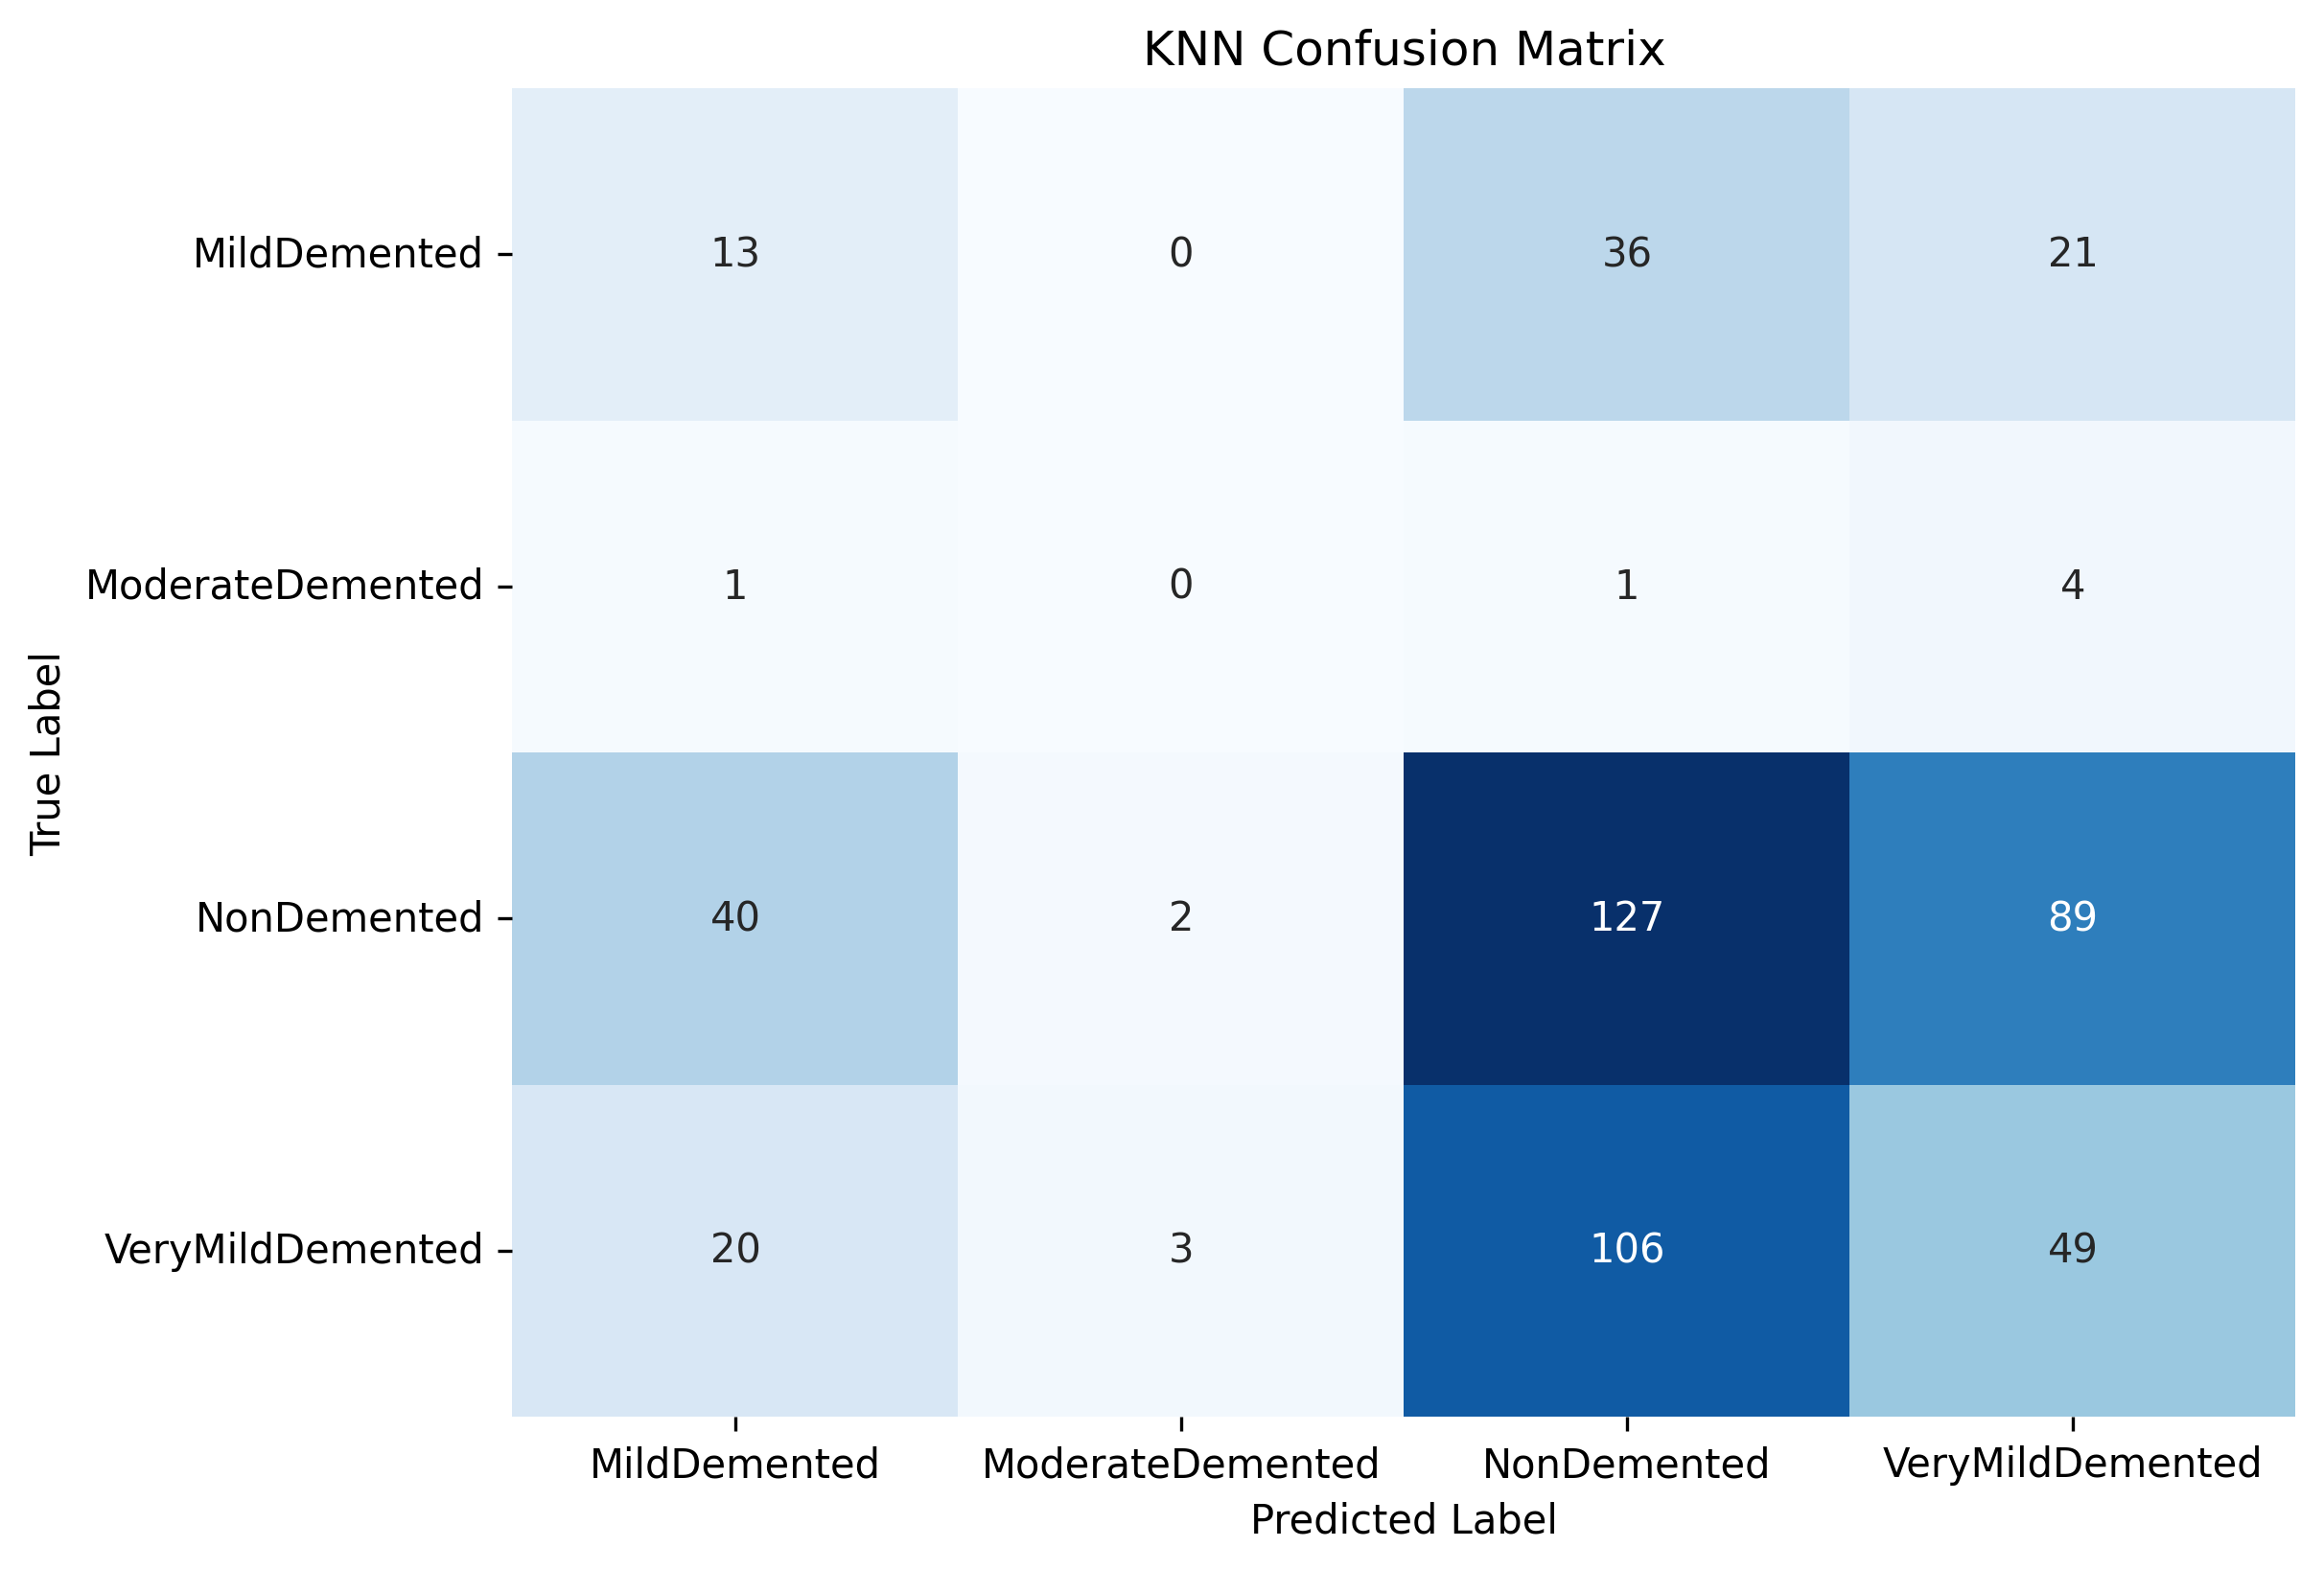

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
conf_matrix_knn = confusion_matrix(test_labels_encoded, test_predictions)

# Calculate True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
TP = conf_matrix_knn[1, 1]
TN = conf_matrix_knn[0, 0]
FP = conf_matrix_knn[0, 1]
FN = conf_matrix_knn[1, 0]

# Calculate sensitivity (recall)
sensitivity_knn = TP / (TP + FN)

# Calculate specificity
specificity_knn = TN / (TN + FP)

# Display the results
print(f'Sensitivity (Recall): {sensitivity_knn:.2f}')
print(f'Specificity: {specificity_knn:.2f}')

# Class labels
your_labels = ['VeryMildDemented', 'NonDemented', 'MildDemented', 'ModerateDemented']

# Create and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(your_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Comparing Predicted Classes with the Actual Classes from the Test Data

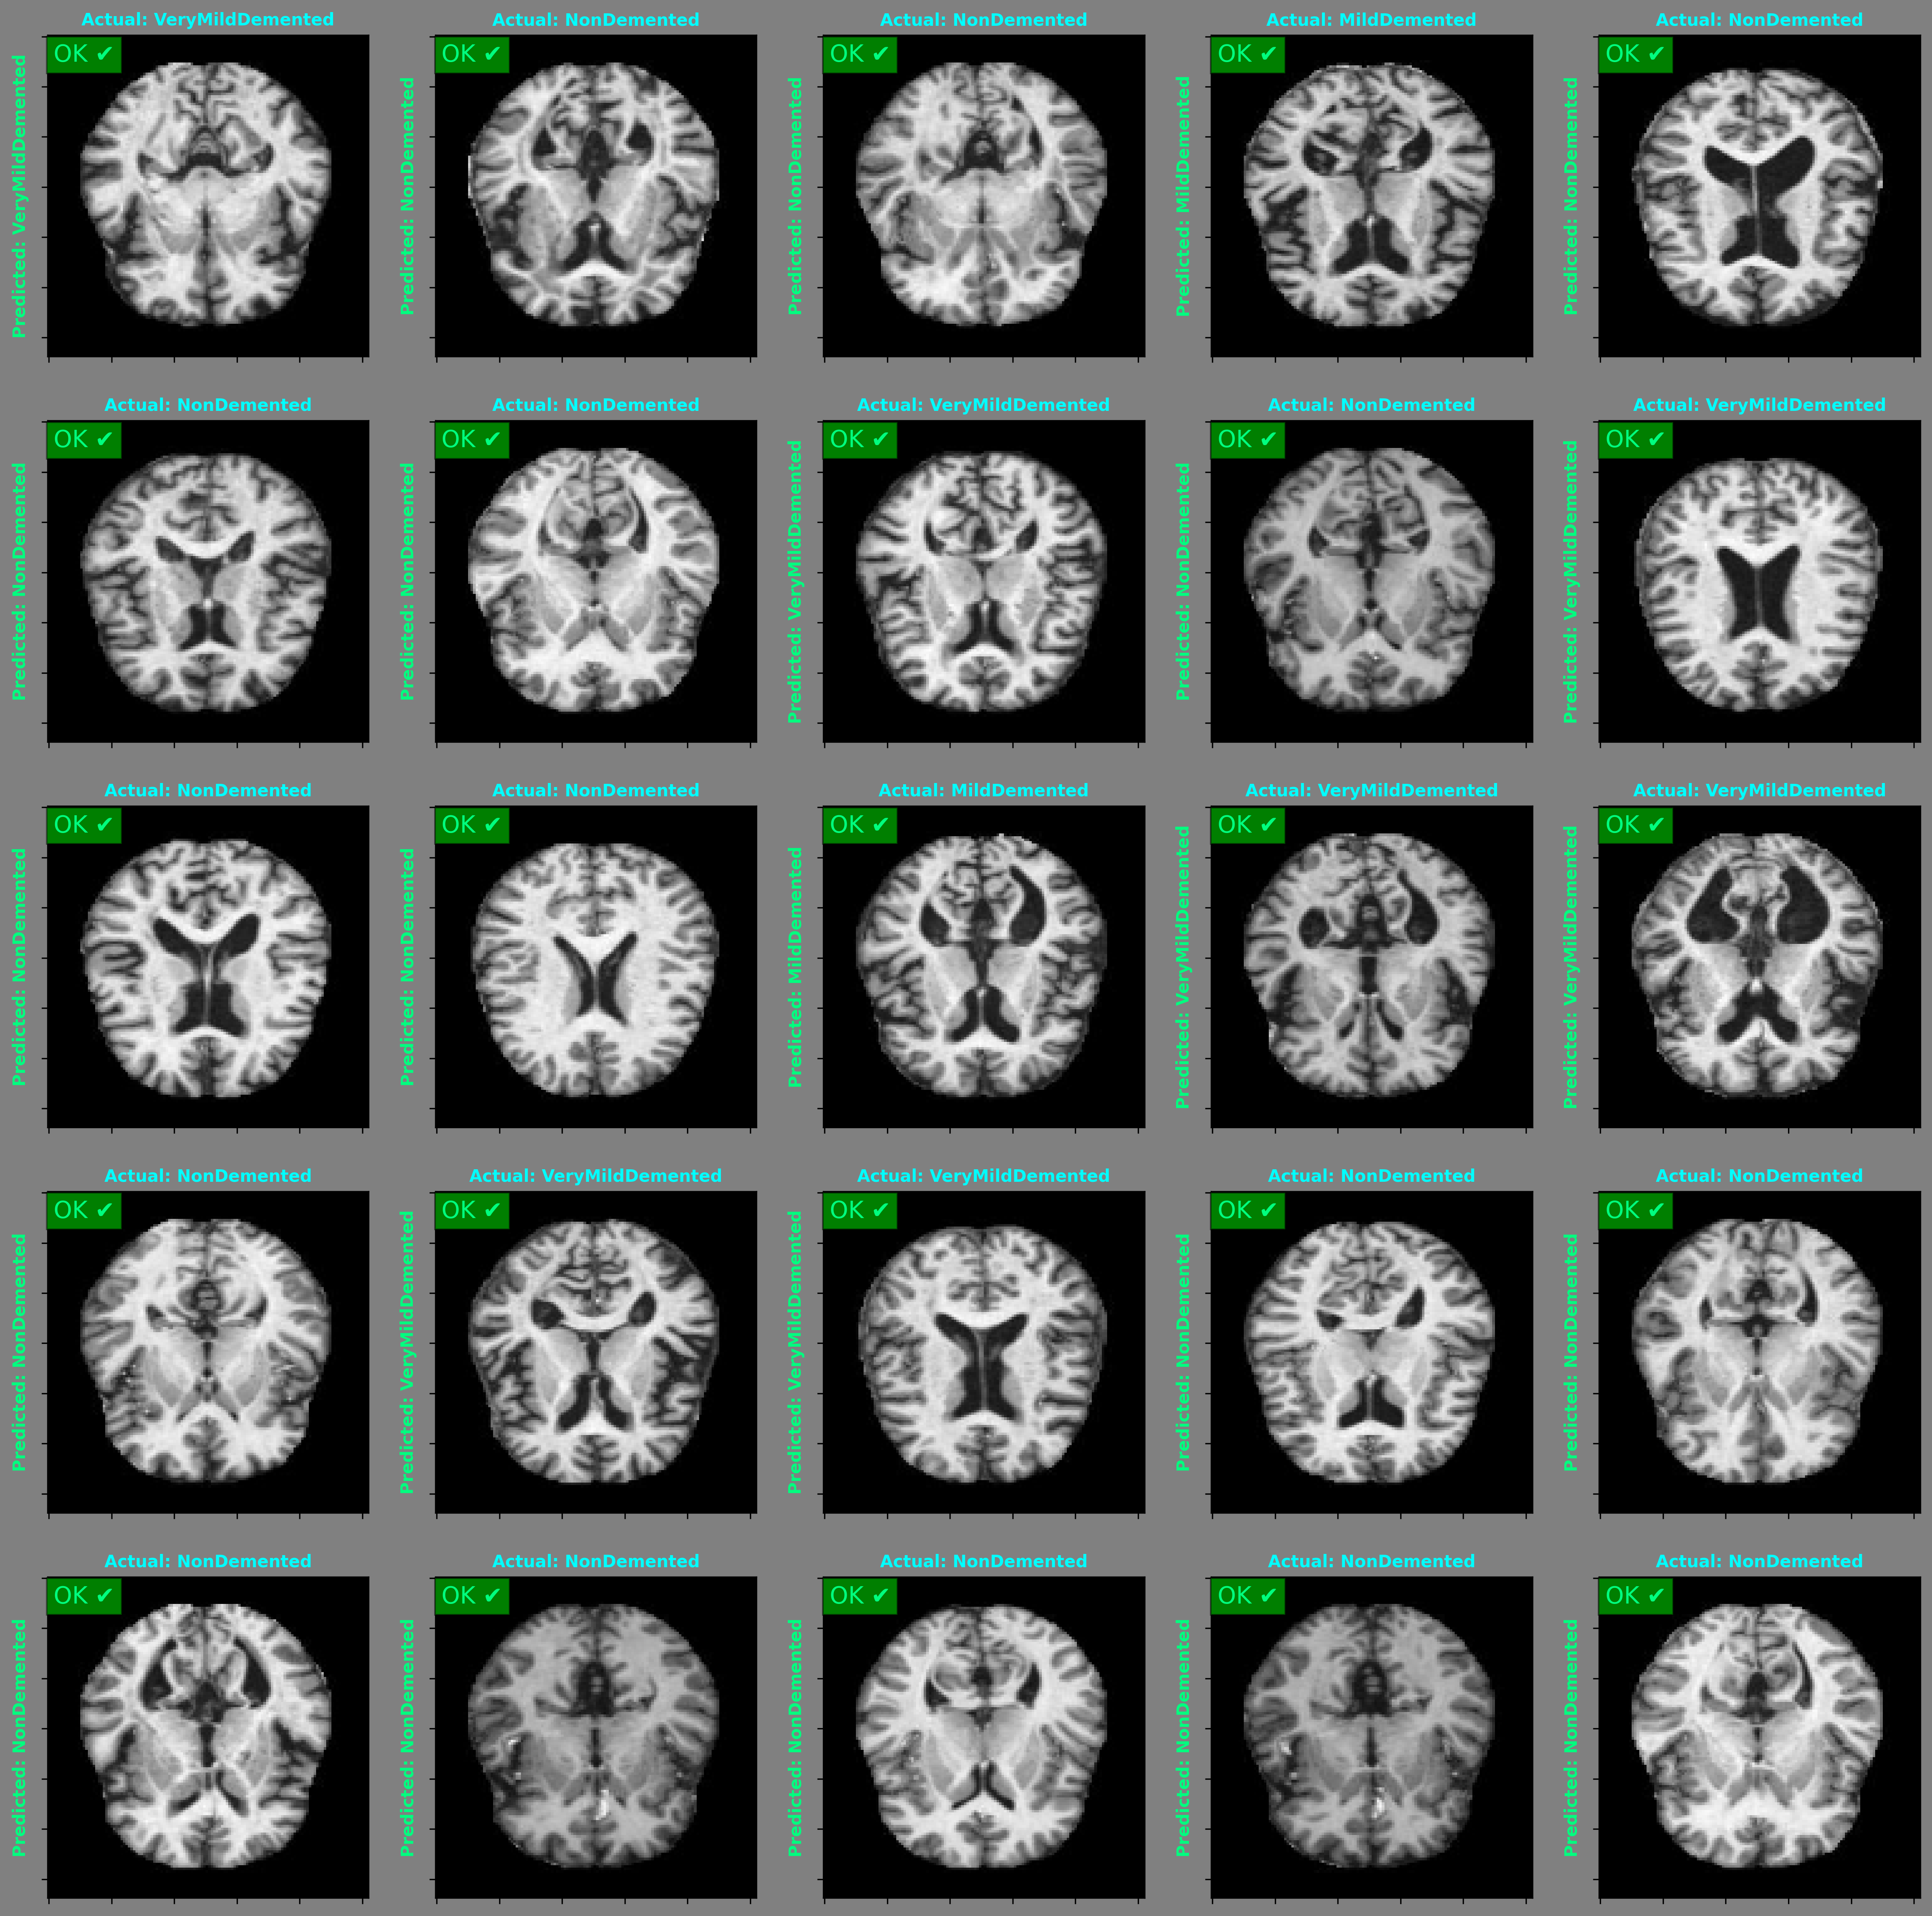

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

Loading the Trained Model

In [ ]:

loaded_model = build_model()  # Assuming build_model() function is available
loaded_model.load_weights('/tmp/checkpoint')  # Path to the saved weights file


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 128)      

Preprocessing the Image:

Before making predictions, you need to preprocess the input image to match the format expected by the model. This involves resizing the image, normalizing pixel values, and adding an extra dimension for the batch.

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))  # Assuming input size is 128x128
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values
    return img_array


Making Predictions:

In [ ]:
# Example of making predictions
image_path = '/content/drive/MyDrive/Alzheimer Dataset/train/MildDemented/mildDem1.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = loaded_model.predict(preprocessed_image)


1/1 [==============================] - 0s 111ms/step


Interpreting Predictions
find the class with the highest probability

In [ ]:
predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]  # Assuming class_names is available
print(f'The model predicts: {predicted_class_name}')


The model predicts: MildDemented


Visualizing Results :
 visualize the original image along with the model's predictions

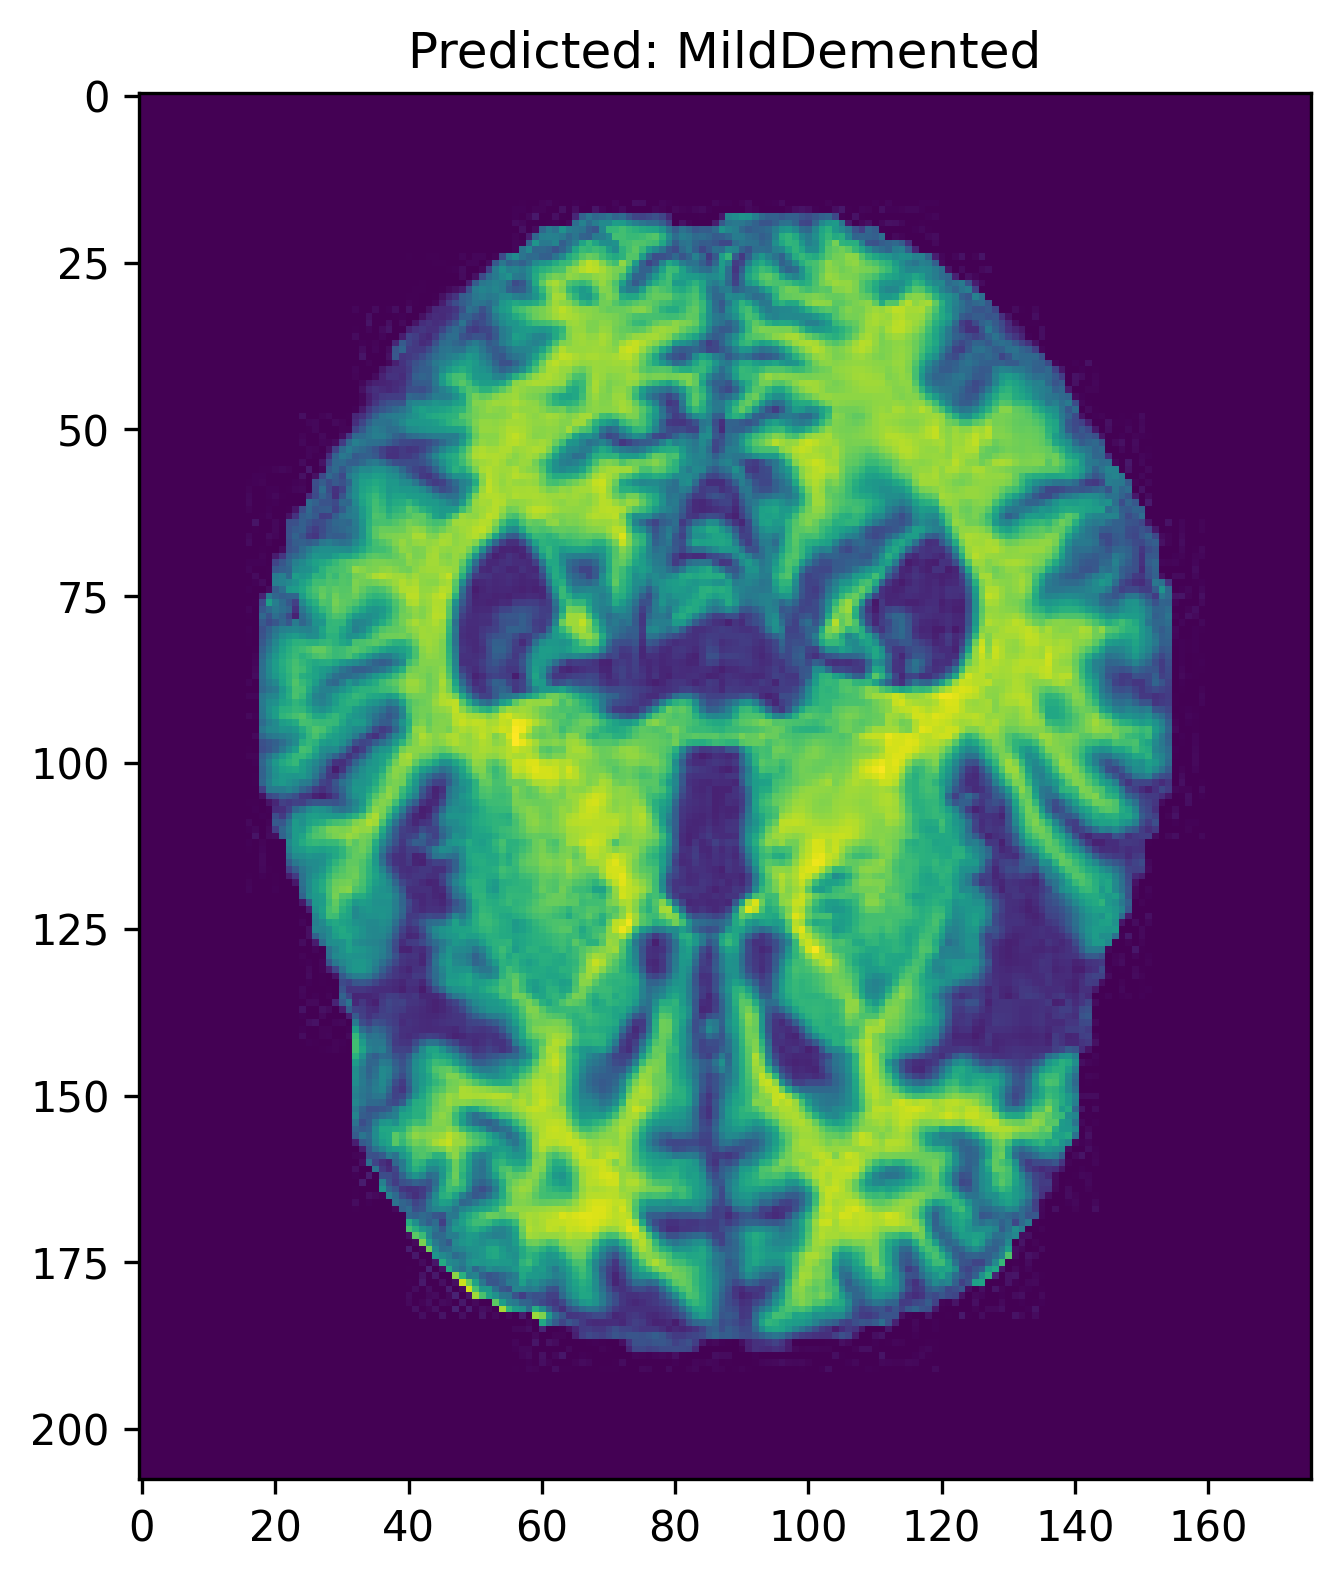

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_name}')
plt.show()


the probabilities for each class

In [ ]:
predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
score = tf.nn.softmax(predictions[0])


In [ ]:
print("Probabilities:", score.numpy())


Probabilities: [0.17585084 0.17585078 0.46911126 0.17918715]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Replace with the path to your image file
img_path = r'/content/drive/MyDrive/example data/MRI.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# Now, img_array is ready to be used for prediction with your model


In [ ]:
# Example of making predictions
image_path = '/content/drive/MyDrive/example data/MRI.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = loaded_model.predict(preprocessed_image)

1/1 [==============================] - 0s 34ms/step


In [ ]:
predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]  # Assuming class_names is available
print(f'The model predicts: {predicted_class_name}')


The model predicts: VeryMildDemented


In [ ]:

# Example of making predictions
image_path = '/content/drive/MyDrive/example data/moderateDem0.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = loaded_model.predict(preprocessed_image)

1/1 [==============================] - 0s 32ms/step


In [ ]:
predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]  # Assuming class_names is available
print(f'The model predicts: {predicted_class_name}')


The model predicts: ModerateDemented


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 128)      

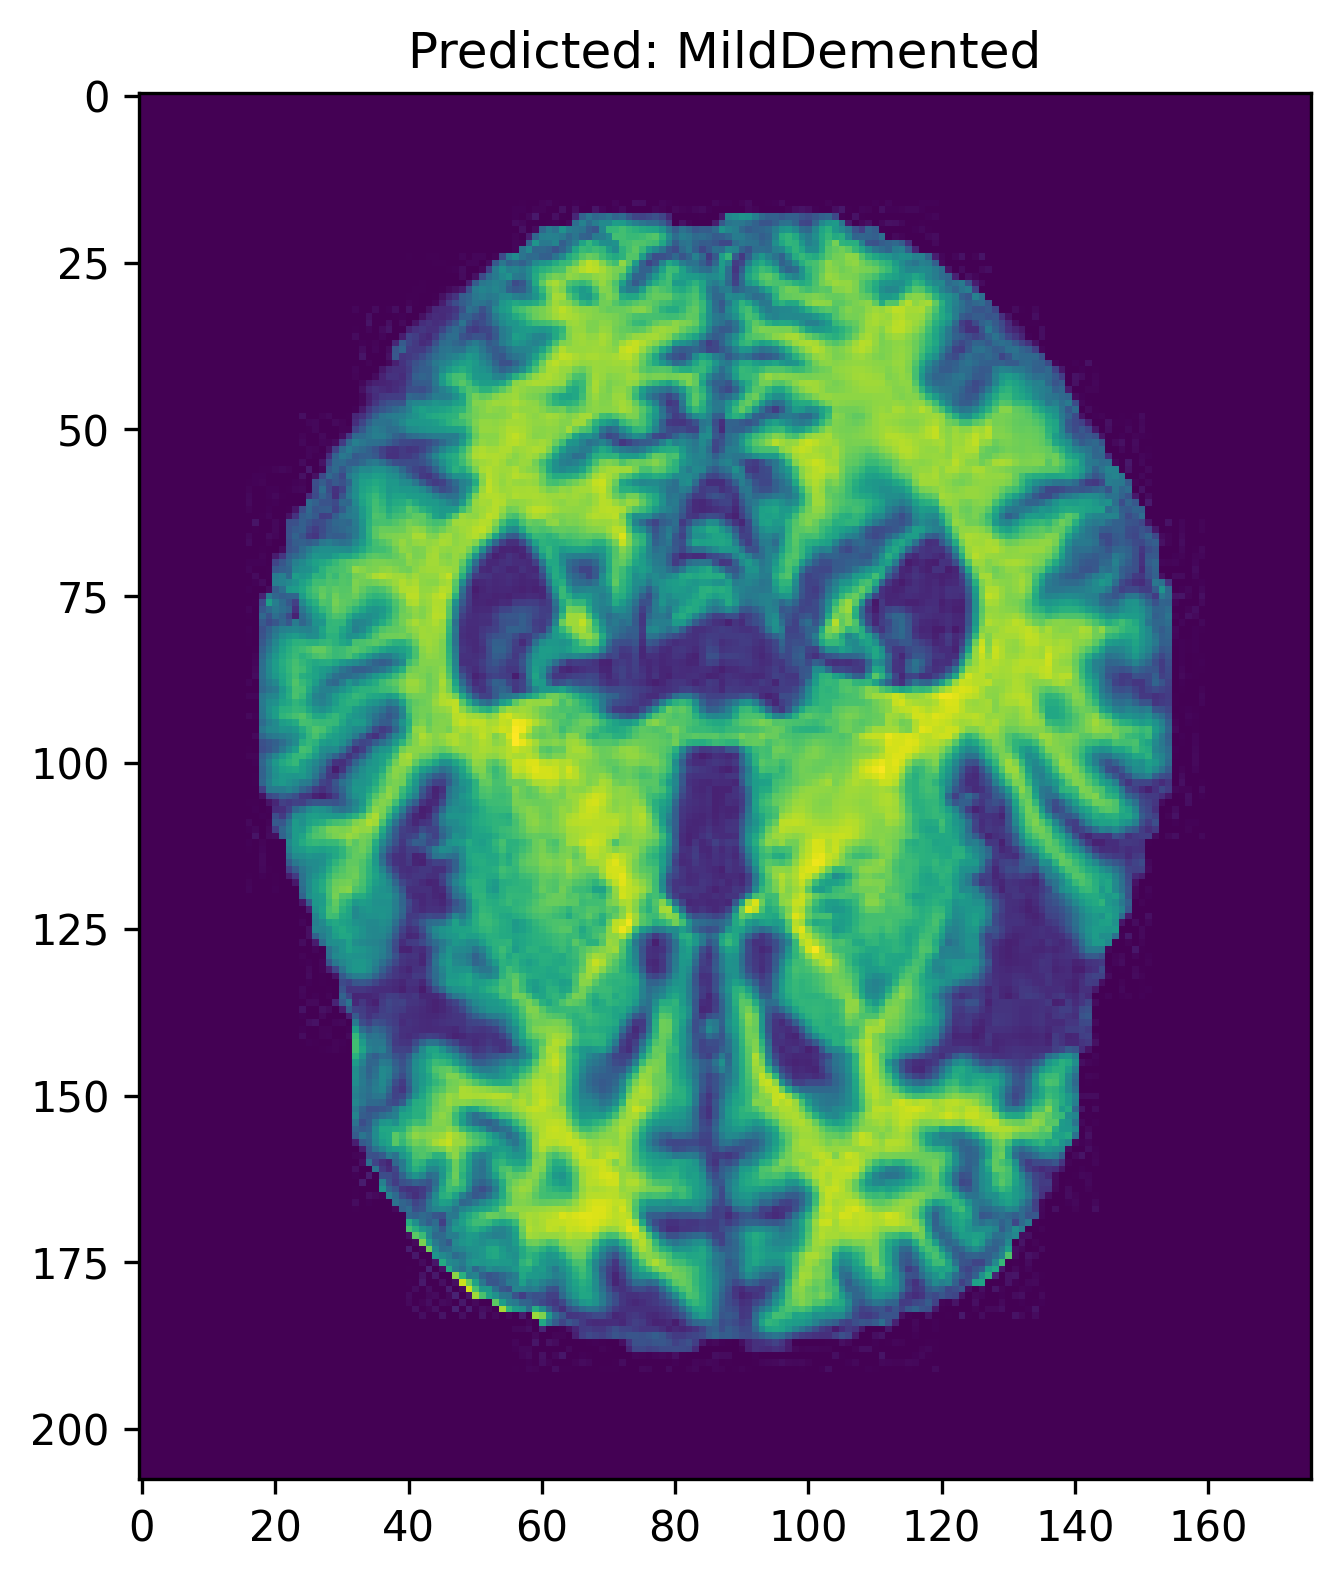

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to preprocess an image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Example of making predictions
image_path = '/content/drive/MyDrive/Alzheimer Dataset/train/MildDemented/mildDem1.jpg'
preprocessed_image = preprocess_image(image_path)

# Load the trained model
loaded_model = build_model()  # Assuming build_model() function is available
loaded_model.load_weights('/tmp/checkpoint')  # Path to the saved weights file

# Make predictions
predictions = loaded_model.predict(preprocessed_image)

# Interpret predictions
predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]
print(f'The model predicts: {predicted_class_name}')

# Visualize the original image along with predictions
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_name}')
plt.show()


In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/saved_model')
